Spinoff new notebooks from this one.

# Initialize Notebook

## Imports

In [208]:
import math
import random
import pandas as pd
import numpy as np
import itertools as IT

import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [79]:
# # Class to suppress printing in specific functions.
# # Usage: add supress=True as an argument to a function.
# # Wrap print statements inside the following:
# #      with SuppressPrints():
# #           {statements to control}
# class SuppressPrints:
#     # https://stackoverflow.com/questions/8391411/suppress-calls-to-print-python
#     def __init__(self, suppress=True):
#         self.suppress = suppress

#     def __enter__(self):
#         if self.suppress:
#             self._original_stdout = sys.stdout
#             sys.stdout = open(os.devnull, 'w')

#     def __exit__(self, exc_type, exc_val, exc_tb):
#         if self.suppress:
#             sys.stdout.close()
#             sys.stdout = self._original_stdout

## Load Subset of Data into Pandas Dataframe

In [375]:
df_aisle_index = pd.read_csv('../data/instacart-market-basket-analysis/aisles.csv')
print(df_aisle_index.shape)
df_dept_index = pd.read_csv('../data/instacart-market-basket-analysis/departments.csv')
print(df_dept_index.shape)
df_prod_index = pd.read_csv('../data/instacart-market-basket-analysis/products.csv')
print(df_prod_index.shape)

(134, 2)
(21, 2)
(49688, 4)


,aisle_id,aisle
aisle_id,,
1,1,prepared soups salads
2,2,specialty cheeses
3,3,energy granola bars
4,4,instant foods
5,5,marinades meat preparation


## Load Order Log, and Order Products

In [6]:
# define subset of data
# Take a sample of the 10,000 users represented in the data

# randomized version
# np.random.seed(4444)
# user_sample_list = np.random.choice(a=range(1,10000,1), size=300, replace=False)

user_subset = range(1,501, 1)

print('generated user subset of size: ', len(user_subset))

generated user subset of size:  500


In [7]:
# Create a generalized mask that filters rows
# which are not applicable to the sampled users.
#
# masked_df = pd.DataFrame(
#     columns=['user_id']
# )
#
# user_mask = ([
#     (masked_df.user_id.isin(user_sample_list))
# ])

df_orders_log = pd.DataFrame(
    columns=['order_id','user_id','eval_set','order_number',
             'order_dow','order_hour_of_day','days_since_prior_order']
)

# import the orders csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset


def valid_user(chunks):
    for chunk in chunks:
        mask = chunk.user_id.isin(user_subset)
        yield chunk.loc[mask]

In [8]:
# read in orders
filename = '../data/instacart-market-basket-analysis/orders.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_orders_log = pd.concat(valid_user(chunks))

In [9]:
print(sys.getsizeof(df_orders_log)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/orders.csv').st_size//1000000,'MB')

0.960604 MB vs  108 MB


In [10]:
# compile a list of unique orders that originate from our user sample

orders_subset = df_orders_log.order_id.unique()
print(orders_subset.shape)

def valid_order(chunks):
    for chunk in chunks:
        mask = chunk.order_id.isin(orders_subset)
        yield chunk.loc[mask]

(8142,)


In [484]:
df_order_prods__prior = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order','reordered']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset



# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__prior.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__prior = pd.concat(valid_order(chunks))

In [12]:
print(sys.getsizeof(df_order_prods__prior)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__prior.csv').st_size//1000000,'MB')
print(df_order_prods__prior.shape)

3.097032 MB vs  577 MB
(77425, 4)


In [485]:
df_order_prods__train = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__train.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__train = pd.concat(valid_order(chunks))

In [14]:
print(sys.getsizeof(df_order_prods__train)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__train.csv').st_size//1000000,'MB')

0.135472 MB vs  24 MB


# Dynamic Cart Completions, Beginning Day 1, Batch Training

This model proposes a dynamic shopping cart "completer" system for deployment in the Instacart shopping interface. Users with pre-determined shopping intent should receive quality of life improvement when the cart-completer displays the next

The cart-completer panel in this instance offers a limited set of recommendations (~5) in a visible panel.

The model should be...

### 1: Agnostic to the Amount of Data

The model should be able to operate from day one, with limited observations.

### 2: Evolve Strategy as Data Quality Increases

The model will re-train at regular intervals across a stream of orders. Batches of orders represent days, at which point time-intensive re-train can take place.

# Model Evaluation Schema

A custom evaluation metric has been calculated for this purpose. The cart-completer only needs one of it's 5-10 alloted recommendation slots to contain the next item.

### Baseline Algorithm: Recommend Products By Global Popularity

As a baseline, let's create a simple algorithm that simply returns a random 5 products from the top 50 most popular products. We hope to do better than this algorithm by engineering all kinds of user- and product-specific features.

In [226]:
## NAIVE MODEL - Product Popularity Focused ##

# code to return top 50 products
# df_order_prods__prior.groupby('product_id').agg(
#     {'order_id':'nunique'}
# ).sort_values('order_id',ascending=False).index.values[:50]

class NaiveTopProducts(object):
    '''
    
    A naive product recommendation algorithm,
    based on overal product popularity.
    
    '''
    
    def __init__(self):
    
        self.type = 'naive'
    
    def fit(self, order_train):
        '''
        
        Pull top 50 products from dataframe.
        
        '''
        
        self.top100 = set(order_train.groupby('product_id').agg(
            {'order_id':'nunique'}
        ).sort_values('order_id',ascending=False).index.values[:100])
        
    def predict(self, n=5):
        
        return random.sample(self.top100, n)

In [228]:
naive_model = NaiveTopProducts()
naive_model.fit(df_order_prods__prior)
preds = naive_model.predict()

[47626, 16759, 5876, 44359, 42265]

### Simulate Dynamic Product Recommendation

In [512]:
def SimulateDynamicRec(order_rows, model, verbose=False):
    
    assert type(order_rows) == type(pd.DataFrame())
    cart = set([])
    
    order_rows = order_rows.sort_values('add_to_cart_order')
    
    if verbose:
        print('testing the following order:\n', order_rows)
    
    total = 0
    guessed = 0
    
    # progress through order one at a time
    for index, row in order_rows.iterrows():
        
        ### Recommend 5 New Products ###
        
        try:
            #### CHECK MODEL TYPE #####
            model_type = model.type
#             print('model type is: ', model_type)
            if model_type in ['naive','reordered']:
                recommendations = model.top100
            
            
            # Exclude items already in cart.
            rec5 = random.sample((recommendations - cart), 5)
            
        except:
            #### OTHER MODELS #####
            pass
        
        
        total += 1
        success = False
        
        actual_next = row['product_id']
        
        if actual_next in rec5:
            success = True
            guessed += 1
        
        # debug output
        if verbose:
#             print(f'Cart is {cart}.\nRecommending {rec5}.')
            if success:
                print(f'Guessed {actual_next}!\n')
                continue
            else:
#                 print(f'Oops, {actual_next} wasn\'t in recommendation list.')
                continue
        
        cart.add(actual_next)
    
    # rel_pct = % of trials where recommendations were relevant to next purchase.
    rel_pct = guessed/total
    
    if verbose:
        print(f'Got {rel_pct}% right of {total}.')
    
    return rel_pct

In [259]:
def DynamicRecScore(model, trials = 100):

    relevancies = []
    
    unique_train_orders = set(df_order_prods__train.order_id.unique())
#     print(len(unique_train_orders))
    
    # If there aren't enough training datapoints.
    if trials > len(unique_train_orders):
        trials = len(unique_train_orders)
    
    for order_id in random.sample(unique_train_orders, trials):
        
#         test_order = df_order_prods__train.sample().order_id.values[0]

        test_order_rows = df_order_prods__train[df_order_prods__train.order_id == order_id]
        rel_pct = SimulateDynamicRec(test_order_rows, model,verbose=False)
        relevancies += [rel_pct]
        
    return np.mean(relevancies)

## Score Naive Top Products Model

Run simulation of user interactive with Naive Top Products as recommender.

In [506]:
# Simple cross validation of naive algorithm:

n_trials = 300
relevancies = []
for i in range(5):
    relevancies += [DynamicRecScore(model=naive_model, trials=n_trials)]
    
print(f'Mean dynamic suggestion relevancy score, Naive Algorithm, n={n_trials}:')
print(np.mean(relevancies))

Mean dynamic suggestion relevancy score, Naive Algorithm, n=300:
0.011403517985996401


# Single Dataframe EDA

## EDA – Products

In [269]:
df_prod_index.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


## EDA – Aisles

In [14]:
df_aisle_index.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


## EDA – Depts

In [15]:
df_dept_index.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


## EDA – Orders

In [268]:
df_orders_log.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


## EDA - Order Products

### Prior

In [265]:
print(df_order_prods__prior.shape)
df_order_prods__prior.head(3)

(77425, 4)


,order_id,product_id,add_to_cart_order,reordered
333,40,10070,1,1
334,40,42450,2,1
335,40,33198,3,1


In [264]:
# inspect an individual order from prior
df_order_prods__prior[df_order_prods__prior.order_id == 1483].head(3)

,order_id,product_id,add_to_cart_order,reordered
14111,1483,32818,1,1
14112,1483,27582,2,1
14113,1483,12302,3,1


### Train

In [387]:
print(df_order_prods__train.shape)
df_order_prods__train.head(1)

(3386, 4)


,order_id,product_id,add_to_cart_order,reordered
239,988,45061,1,0


In [388]:
# inspect an individual order from train
df_order_prods__train[df_order_prods__train.order_id == 988]

,order_id,product_id,add_to_cart_order,reordered
239,988,45061,1,0
240,988,28464,2,0
241,988,12626,3,0
242,988,4818,4,1


# Merge, Append Aisle/Department Columns to Order Log

In [490]:
df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__prior = df_order_prods__prior[['order_id','product_id','add_to_cart_order','reordered']]

df_order_prods__train = pd.merge(
    df_order_prods__train,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__train = df_order_prods__train[['order_id','product_id','add_to_cart_order','reordered']]


df_order_prods__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,40,10070,1,1
1,116744,10070,3,1
2,120295,10070,2,1
3,247775,10070,2,1
4,405284,10070,1,1


# User Profiles

## Initialize User Dataframe

In [279]:
# Create a users database with some historical information for each user

df_user_profs = pd.DataFrame()
df_user_profs['user_id'] = user_subset
# df_user_profs.set_index('user_id', inplace=True)
df_user_profs.head(3)

,user_id
0,1
1,2
2,3


## Generate High-level User Features

### User Order History : `order_id_history` (User)

In [343]:
def query_user_order_history(user_id, df_orders_log):
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_orders = df_orders_log[df_orders_log.user_id == user_id]
    
    return (user_orders[['order_number', 'order_id']]).to_numpy()
 

In [344]:
df_user_profs['order_id_history'] = df_user_profs.user_id.apply(
    query_user_order_history, df_orders_log=df_orders_log
)

In [345]:
df_user_profs.head(1)

,user_id,order_id_history,num_orders
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11


### Unique Order Count (User)

In [346]:
df_user_profs['num_orders'] = df_user_profs.order_id_history.apply(lambda x: len(x))
df_user_profs.head(2)

,user_id,order_id_history,num_orders
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15


### Order Sizes (User)

In [309]:
(df_order_prods[df_order_prods.order_id == 2539329]
                              .groupby('order_id')
).agg('nunique')['product_id']

,order_id,product_id,add_to_cart_order,reordered
order_id,,,,
2539329,1,5,5,1


In [373]:
## Average Order Sizes by User ##

run_limit = 5
run_count = 0

def avg_user_order_sizes(order_id_history, df_order_prods):
    
#     global run_count
#     global run_limit
    
#     run_count += 1
#     if run_count > run_limit:
#         return 0

    
#     print(order_id_history)
    order_id_list = order_id_history[:,1]
#     print(order_id_list)
#     print(type(order_id_list))

    avg_order_size = (
        df_order_prods[df_order_prods.order_id.isin(order_id_list)]              
        .groupby('order_id')
        .agg('nunique')
    ).mean()['product_id']

#     print(avg_order_size)
    return avg_order_size

df_user_profs['avg_order_size'] = (df_user_profs.order_id_history
                                    .apply(avg_user_order_sizes, df_order_prods=df_order_prods)
                                   )

df_user_profs.head()

,user_id,order_id_history,num_orders,avg_order_sizes,avg_order_size
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11,6.363636,6.363636
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15,15.066667,15.066667
2,3,"[[1, 1374495], [2, 444309], [3, 3002854], [4, ...",13,7.333333,7.333333
3,4,"[[1, 3343014], [2, 2030307], [3, 691089], [4, ...",6,3.600000,3.600000
4,5,"[[1, 2717275], [2, 1909121], [3, 2267326], [4,...",5,9.200000,9.200000


### Departmental Unique Check-ins Dictionary (User)

In [ ]:
# Create a dictionary with department IDs as keys
# each value is the number of unique department check-ins.
# i.e. An order with two products from the same department
# should count as 1 unique check-in.

user_hist['dept_dict'] = dict(zip(depts.department_id.values,0*depts.department_id.values))

def unique_dept_checkins(user_id, orders, order_prods, subset='prior'):
    
    user_orders = orders[(orders.user_id == user_id) & (orders.eval_set == subset)]
    
    gb_order = user_orders.groupby('order_id')
    
    
    
    for group in gb_order:
        
        
    
    
    return order_sizes


user_hist['prior_order_sizes'] = pd.Series(user_hist.index.values).apply(
    order_sizes,
    orders=orders,
    order_prods=all_order_prods
)

### Total Orders to Date (User)

### Unique Orders (User)

# Department Profiles

In [455]:
# Create a department profile dataframe

df_dept_profs = pd.DataFrame()
df_dept_profs['department_id'] = df_dept_index.department_id

In [456]:
df_dept_profs.head(2)

,department_id
0,1
1,2


### Orders / Department

In [458]:
# Calculate number of orders in each department.
dept_nunique = df_order_prods.groupby('department_id').nunique()['order_id'].reset_index()
dept_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_dept_profs = pd.merge(df_dept_profs, dept_nunique, on='department_id')
df_dept_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

,department_id,num_orders_x,num_orders_y
0,1,2779,2779
1,2,86,86
2,3,1996,1996


# Aisle Profiles

# Product Profiles

In [479]:
# Create a product profile dataframe

df_prod_profs = pd.DataFrame()
df_prod_profs['product_id'] = df_prod_index.product_id

In [480]:
# Calculate number of orders for each product.
prod_nunique = df_order_prods.groupby('product_id').nunique()['order_id'].reset_index()
prod_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_prod_profs = pd.merge(df_prod_profs, prod_nunique, on='product_id')
df_prod_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

,product_id,num_orders
0,1,2
1,4,1
2,9,1


In [481]:
# Calculate number of RE-orders for each product.
prod_reorder_count = df_order_prods.groupby('product_id').sum()['reordered'].reset_index()
prod_reorder_count.rename(columns={'order_id':'num_orders'}, inplace=True)

df_prod_profs = pd.merge(df_prod_profs, prod_reorder_count, on='product_id')
df_prod_profs.sample(3)
# df_user_profs.set_index('user_id', inplace=True)

,product_id,num_orders,reordered
6041,27255,1,0
2130,9641,3,2
9110,40762,1,0


In [477]:
df_prod_profs.sample(3)

,product_id,num_orders,reordered
8685,38912,4,3
470,2186,2,1
10016,44911,1,0


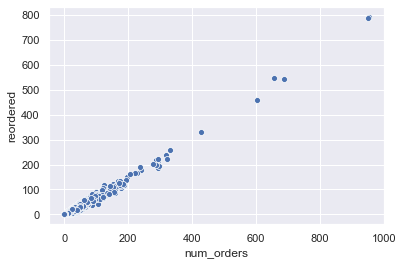

In [518]:
sns.scatterplot(df_prod_profs['num_orders'], df_prod_profs['reordered'])

## Improved Popularity Recommender: Using Top "Reorders"

Using some of the elementary product profile information, we can now evolve our baseline recommender to focus on products that have been re-ordered.

In [513]:
## NAIVE MODEL - RE-ORDER Popularity Focused ##

# code to return top 50 products
# df_order_prods__prior.groupby('product_id').agg(
#     {'order_id':'nunique'}
# ).sort_values('order_id',ascending=False).index.values[:50]

class TopReorderedProducts(object):
    '''
    
    A naive product recommendation algorithm,
    based on overal product popularity.
    
    '''
    
    def __init__(self):
    
        self.type = 'reordered'
    
    def fit(self, prod_profs):
        '''
        
        Pull top 50 products from dataframe.
        
        '''
        
        self.top100 = set(prod_profs
                          .sort_values(by='reordered', ascending=False)
                          .product_id
                          .values[:100]
                         )
        
    def predict(self, n=5):
        
        return random.sample(self.top100, n)

In [514]:
reorder_model = TopReorderedProducts()
reorder_model.fit(df_prod_profs)
preds = reorder_model.predict()
preds

[21709, 30391, 27966, 33787, 45504]

In [516]:
### n=300 trials of naive algorithm:

n_trials = 300
relevancies = []
for i in range(5):
    relevancies += [DynamicRecScore(model=reorder_model, trials=n_trials)]
    
print(f'Mean dynamic suggestion relevancy score, Naive Algorithm, n={n_trials}:')
print(np.mean(relevancies))

Mean dynamic suggestion relevancy score, Naive Algorithm, n=300:
0.011634510190387169


# AWS / SQL Stuff

In [ ]:
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

params = {
    'host': '18.220.115.81',
    'user': 'ubuntu',
    'port': 5432
    
# Connect and create database, disconnect, and reconnect to the right database
connection = connect(**params, dbname='ubuntu')
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
connection.cursor().execute('CREATE DATABASE store;')
connection.close()